<a href="https://colab.research.google.com/github/abbyWoot/AML/blob/master/AML_Project7_Team2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Advanced Machine Learning Project6**

@Team 2: Joe, Getong, Abby
Apple Stock

In [0]:
#Set Up. 
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import numpy as np
import os
import sys
import time
import pandas as pd 
from tqdm._tqdm_notebook import tqdm_notebook
import pickle
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras import optimizers
# from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import logging

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

params = {
    "batch_size": 20,  # 20<16<10, 25 was a bust
    "epochs": 300,
    "lr": 0.00010000,
    "time_steps": 60
}

iter_changes = "dropout_layers_0.4_0.4"

In [0]:
# Download the data
import urllib
import os

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/fsclsnow/AML/master/"
AAPL_PATH = os.path.join("Data")
AAPL_URL_5years = DOWNLOAD_ROOT + "AAPL_2015-2019.csv"
AAPL_URL_1year = DOWNLOAD_ROOT + "AAPL_2019-2020.csv"

In [0]:
import pandas as pd

def load_aapl_data(aapl_path=AAPL_PATH):
    csv_path = os.path.join(DOWNLOAD_ROOT, aapl_path, "AAPL_2015-2019.csv")
    return pd.read_csv(csv_path)

In [0]:
aapl = load_aapl_data()
aapl.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,4/27/2015,132.309998,133.130005,131.149994,132.649994,122.072395,96954200.0
1,4/28/2015,134.460007,134.539993,129.570007,130.559998,120.149078,118924000.0
2,4/29/2015,130.160004,131.589996,128.300003,128.639999,118.382187,63386100.0
3,4/30/2015,128.639999,128.639999,124.580002,125.150002,115.170479,83195400.0
4,5/1/2015,126.099998,130.130005,125.300003,128.949997,118.667458,58512600.0


In [0]:
aapl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1006 non-null   object 
 1   Open       1006 non-null   float64
 2   High       1006 non-null   float64
 3   Low        1006 non-null   float64
 4   Close      1006 non-null   float64
 5   Adj Close  1006 non-null   float64
 6   Volume     1006 non-null   float64
dtypes: float64(6), object(1)
memory usage: 69.0+ KB


# Basic RNNs

In [0]:
aapl.shape

(1259, 7)

In [0]:
aapl.isnull().sum()

Date         253
Open         253
High         253
Low          253
Close        253
Adj Close    253
Volume       253
dtype: int64

In [0]:
aapl=aapl.fillna(method = 'pad') #filling the missing values with previous ones
aapl.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [0]:
print('There are {} number of days in the dataset.'.format(aapl.shape[0]))

There are 1259 number of days in the dataset.


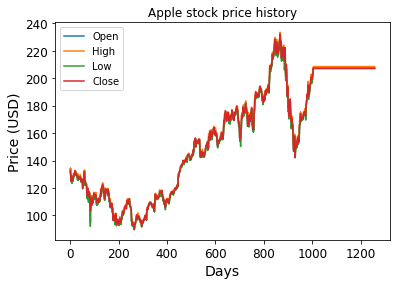

In [0]:
from matplotlib import pyplot as plt
plt.figure()
plt.plot(aapl["Open"])
plt.plot(aapl["High"])
plt.plot(aapl["Low"])
plt.plot(aapl["Close"])
plt.title('Apple stock price history')
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['Open','High','Low','Close'], loc='upper left')
plt.show()

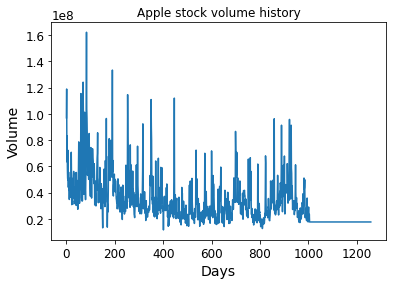

In [0]:
plt.figure()
plt.plot(aapl["Volume"])
plt.title('Apple stock volume history')
plt.ylabel('Volume')
plt.xlabel('Days')
plt.show()

In [0]:
aapl.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03
mean,157.653098,158.888164,156.587125,157.652463,152.538954,3.230643e+07
std,40.733537,40.938304,40.729689,40.679411,42.133720,1.750447e+07
min,90.000000,91.669998,89.470001,90.339996,85.192909,1.147590e+07
25%,116.494999,117.410000,115.614998,116.355004,109.802921,1.835465e+07
50%,158.229996,159.750000,156.410004,157.740005,153.474335,2.739010e+07
75%,207.360001,208.479996,206.709999,207.160004,204.270446,3.906510e+07
max,230.779999,233.470001,229.779999,232.070007,227.300339,1.622063e+08


#Manipulate data 
* choose a specific stock
* drop feature: volume
* normalize stock data
* create train, validation and test data sets
#Normalizing the data
The data is not normalized and the range for each column varies, especially Volume. Normalizing data helps the algorithm in converging i.e. to find local/ global minimum efficiently. We use MinMaxScaler from Sci-kit Learn. But before that we have to split the dataset into training and testing datasets. Also We will convert the DataFrame to ndarray in the process.

In [0]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

train_cols = ["Open","High","Low","Close","Volume"]
aapl_train, aapl_test = train_test_split(aapl, train_size=0.8, test_size=0.2, shuffle=False)
print("Train and Test size", len(aapl_train), len(aapl_test))
# scale the feature MinMax, build array
x = aapl_train.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(df_remain.loc[:,train_cols])

Train and Test size 1007 252


In [0]:
TIME_STEPS = params["time_steps"]
BATCH_SIZE = params["batch_size"]
stime = time.time()

In [0]:
def build_timeseries(mat, y_col_index):
    """
    Converts ndarray into timeseries format and supervised data format. Takes first TIME_STEPS
    number of rows as input and sets the TIME_STEPS+1th data as corresponding output and so on.
    :param mat: ndarray which holds the dataset
    :param y_col_index: index of column which acts as output
    :return: returns two ndarrays-- input and output in format suitable to feed
    to LSTM.
    """
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    print("dim_0",dim_0)
    for i in tqdm_notebook(range(dim_0)):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
#         if i < 10:
#           print(i,"-->", x[i,-1,:], y[i])
    print("length of time-series i/o",x.shape,y.shape)
    return x, y


In [0]:
def trim_dataset(mat,batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if no_of_rows_drop > 0:
        return mat[:-no_of_rows_drop]
    else:
        return mat

Also mix the batch size with this. Let’s assume we choose batch size of 2. Then input-output pair 1 (green rectangle) and pair 2 (blue rectangle) would constitute batch one. And so on. Here is the python code snippet to do this:

In [0]:
x_t, y_t = build_timeseries(x_train, 3)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t,BATCH_SIZE)
x_temp, y_temp = build_timeseries(x_test, 3)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)

dim_0 947



length of time-series i/o (947, 60, 5) (947,)
dim_0 192



length of time-series i/o (192, 60, 5) (192,)


In [0]:
def create_model():
    lstm_model = Sequential()
    # (batch_size, timesteps, data_dim)
    lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]),
                        dropout=0.0, recurrent_dropout=0.0, stateful=True, return_sequences=True,
                        kernel_initializer='random_uniform'))
    lstm_model.add(Dropout(0.4))
    lstm_model.add(LSTM(60, dropout=0.0))
    lstm_model.add(Dropout(0.4))
    lstm_model.add(Dense(20,activation='relu'))
    lstm_model.add(Dense(1,activation='sigmoid'))
    optimizer = optimizers.RMSprop(lr=params["lr"])
    # optimizer = optimizers.SGD(lr=0.000001, decay=1e-6, momentum=0.9, nesterov=True)
    lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)
    return lstm_model


In [0]:
model = None
try:
    model = pickle.load(open("lstm_model", 'rb'))
    print("Loaded saved model...")
except FileNotFoundError:
    print("Model not found")

Model not found


In [0]:
x_temp, y_temp = build_timeseries(x_test, 3)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)

print("Test size", x_test_t.shape, y_test_t.shape, x_val.shape, y_val.shape)

dim_0 192



length of time-series i/o (192, 60, 5) (192,)
Test size (90, 60, 5) (90,) (90, 60, 5) (90,)


In [0]:
 model = create_model()

In [0]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                       patience=40, min_delta=0.0001)

mcp = ModelCheckpoint(os.path.join(DOWNLOAD_ROOT, AAPL_PATH, "AAPL_2015-2019.csv"), monitor='val_loss', verbose=1,
                          save_best_only=True, save_weights_only=False, mode='min', period=1)

csv_logger = CSVLogger(os.path.join(DOWNLOAD_ROOT, AAPL_PATH, "AAPL_2015-2019.csv")
    
history = model.fit(x_t, y_t, epochs=params["epochs"], verbose=2, batch_size=BATCH_SIZE,
                        shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
                        trim_dataset(y_val, BATCH_SIZE)), callbacks=[es, mcp, csv_logger])
    
print("saving model...")
pickle.dump(model, open("model", "wb"))

SyntaxError: ignored

In [0]:
# model.evaluate(x_test_t, y_test_t, batch_size=BATCH_SIZE
y_pred = model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])

Error is 0.10306335149528664 (80,) (80,)
[0.5032081 0.5032081 0.5032081 0.5032081 0.5032081 0.5032081 0.5032081
 0.5032081 0.5032081 0.5032081 0.5032081 0.5032081 0.5032081 0.5032081
 0.5032081]
[0.82424327 0.82424327 0.82424327 0.82424327 0.82424327 0.82424327
 0.82424327 0.82424327 0.82424327 0.82424327 0.82424327 0.82424327
 0.82424327 0.82424327 0.82424327]


In [0]:
# convert the predicted value to range of real data
y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
# min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
# min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[0:15])
print(y_test_t_org[0:15])

[161.65968 161.65968 161.65968 161.65968 161.65968 161.65968 161.65968
 161.65968 161.65968 161.65968 161.65968 161.65968 161.65968 161.65968
 161.65968]
[207.160004 207.160004 207.160004 207.160004 207.160004 207.160004
 207.160004 207.160004 207.160004 207.160004 207.160004 207.160004
 207.160004 207.160004 207.160004]


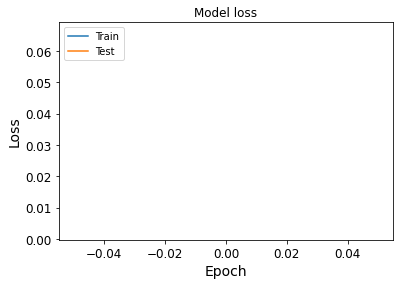

In [0]:
# Visualize the training data
from matplotlib import pyplot as plt
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
#plt.show()

In [0]:
print(model)

In [0]:
y_pred = model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])
y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[0:15])
print(y_test_t_org[0:15])

Error is 0.10306327495459414 (80,) (80,)
[0.5032086 0.5032086 0.5032086 0.5032086 0.5032086 0.5032086 0.5032086
 0.5032086 0.5032086 0.5032086 0.5032086 0.5032086 0.5032086 0.5032086
 0.5032086]
[0.82424327 0.82424327 0.82424327 0.82424327 0.82424327 0.82424327
 0.82424327 0.82424327 0.82424327 0.82424327 0.82424327 0.82424327
 0.82424327 0.82424327 0.82424327]
[161.65976 161.65976 161.65976 161.65976 161.65976 161.65976 161.65976
 161.65976 161.65976 161.65976 161.65976 161.65976 161.65976 161.65976
 161.65976]
[207.160004 207.160004 207.160004 207.160004 207.160004 207.160004
 207.160004 207.160004 207.160004 207.160004 207.160004 207.160004
 207.160004 207.160004 207.160004]


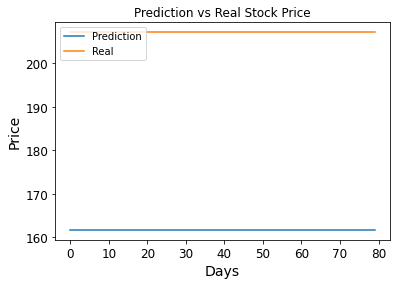

In [0]:
# Visualize the prediction
from matplotlib import pyplot as plt
plt.figure()
plt.plot(y_pred_org)
plt.plot(y_test_t_org)
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
plt.show()